In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from arch import arch_model
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")
from copulalib.copulalib import Copula
from array import array 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX

## 1. Importing Data

In [33]:
# Importing Data
bit_data = yf.download(tickers = 'BTC-USD', start = "2020-04-01", end = "2021-01-01", interval = '1d')
gld_data = yf.download(tickers = 'GLD', start = "2020-04-01", end = "2021-01-01", interval = '1d')
vgk_data = yf.download(tickers = 'VGK', start = "2020-04-01", end = "2021-01-01", interval = '1d')

# Concatenating the adjusted close prices together
adj_close_data = pd.DataFrame(columns = ['BTC', 'GLD', 'VGK'])
adj_close_data['BTC'] = bit_data['Adj Close']
adj_close_data['GLD'] = gld_data['Adj Close']
adj_close_data['VGK'] = vgk_data['Adj Close']

# Filling NaN Values with forward-filling
adj_close_data.fillna(method = "ffill", axis = 0, inplace = True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## 2. Data Processing and Calculating Returns

In [34]:
ret_data = pd.DataFrame(columns = ['BTC', 'GLD', 'VGK'])

# Calculating daily returns for GOLD ETF
ret_data['BTC'] = np.log(adj_close_data['BTC']) - np.log(adj_close_data['BTC'].shift(1))

# Calculating daily returns for GOLD ETF
ret_data['GLD'] = np.log(adj_close_data['GLD']) - np.log(adj_close_data['GLD'].shift(1))

# Calculating daily returns for EQUITY ETF
ret_data['VGK'] = np.log(adj_close_data['VGK']) - np.log(adj_close_data['VGK'].shift(1))

ret_data.dropna(inplace = True)
ret_data

,BTC,GLD,VGK
Date,,,
2020-04-01,0.025778,0.009412,-0.044893
2020-04-02,0.027889,0.016261,0.018911
2020-04-03,-0.008906,0.004925,-0.021088
2020-04-04,0.019726,0.000000,0.000000
2020-04-05,-0.011187,0.000000,0.000000
...,...,...,...
2020-12-27,-0.006251,0.000000,0.000000
2020-12-28,0.030458,-0.003636,0.006789
2020-12-29,0.010198,0.003636,0.007235


## 3. Data Summaries Extreme Values

#### 3.1 Compute the returns for each series.


In [35]:
# Computing the return of each return series 
btc_tot_ret = ret_data['BTC'].sum()
gld_tot_ret = ret_data['GLD'].sum()
vgk_tot_ret = ret_data['VGK'].sum()

print("Bitcoin's return for the given period is: {} %".format(np.round(btc_tot_ret*100, 3)))
print("Gold ETF's return for the given period is: {} %".format(np.round(gld_tot_ret*100, 3)))
print("Equity ETF's return for the given period is: {} %".format(np.round(vgk_tot_ret*100, 3)))
print("")


Bitcoin's return for the given period is: 150.504 %
Gold ETF's return for the given period is: 18.625 %
Equity ETF's return for the given period is: 35.56 %



#### 3.2 Similarly, compute the kurtosis for each series.

In [36]:
# Computing the kurtosis of each return series 
btc_kurt = ret_data['BTC'].kurtosis()
gld_kurt = ret_data['GLD'].kurtosis()
vgk_kurt = ret_data['VGK'].kurtosis()

print("Bitcoin's kurtosis for the given period is: {}".format(btc_kurt))
print("Gold ETF's kurtosis for the given period is: {}".format(gld_kurt))
print("Equity ETF's kurtosis for the given period is: {}".format(vgk_kurt))
print("")

Bitcoin's kurtosis for the given period is: 2.742976185262016
Gold ETF's kurtosis for the given period is: 7.800406418235283
Equity ETF's kurtosis for the given period is: 4.094620668828096



#### 3.3 Use a common metric (BUT NOT 2 SIGMA), or derive your own, to identify an extreme value.  Explain your reasoning.

Here we use the Z Score method for finding the extreme values, meaning that when a values is 3 standard deviations away from the mean of our data series we consider that an extreme, probably rare, realization of the data generating process.

#### 3.4 Apply your metric to each of the return series.

In [37]:
# 3.3 - 3.4 Using z-score method for finding extreme values

# BTC 
btc_high_bound =  ret_data['BTC'].mean() + 3*ret_data['BTC'].std()
btc_low_bound  =  ret_data['BTC'].mean() - 3*ret_data['BTC'].std()
btc_outliers = ret_data['BTC'][(ret_data['BTC'] >= btc_high_bound) | (ret_data['BTC'] <= btc_low_bound)]
print("BTC outlier returns are: ")
print(btc_outliers*100)

# GLD 
gld_high_bound =  ret_data['GLD'].mean() + 3*ret_data['GLD'].std()
gld_low_bound  =  ret_data['GLD'].mean() - 3*ret_data['GLD'].std()
gld_outliers = ret_data['GLD'][(ret_data['GLD'] >= gld_high_bound) | (ret_data['GLD'] <= gld_low_bound)]
print("GLD outlier returns are: ")
print(gld_outliers*100)

# VGK 
vgk_high_bound =  ret_data['VGK'].mean() + 3*ret_data['VGK'].std()
vgk_low_bound  =  ret_data['VGK'].mean() - 3*ret_data['VGK'].std()
vgk_outliers = ret_data['VGK'][(ret_data['VGK'] >= vgk_high_bound) | (ret_data['VGK'] <= vgk_low_bound)]
print("VGK outlier returns are: ")
print(vgk_outliers*100)

BTC outlier returns are: 
Date
2020-04-29    11.984141
2020-05-10    -9.133875
2020-07-27    10.400867
2020-09-03   -10.802491
2020-11-05     9.741581
2020-11-26    -8.820525
Name: BTC, dtype: float64
GLD outlier returns are: 
Date
2020-08-11   -5.518973
2020-08-19   -3.207438
2020-11-09   -4.528086
Name: GLD, dtype: float64
VGK outlier returns are: 
Date
2020-04-01   -4.489287
2020-04-06    4.822468
2020-04-15   -4.173800
2020-05-18    4.420724
2020-06-11   -6.042110
2020-10-28   -3.935251
Name: VGK, dtype: float64


## 4. Data Comparison Copulas

#### 4.1 Pick 2 of the series  that had the most extreme values.
Here, we chose ETF and Bitcoin given that they had the most extreme values.

In [38]:
# Utility method to calculate the returns of a provided quarter

def get_data(df, year_start, year_end, month_start, month_end, column):
    return df[(df.index >= f"{year_start}-{month_start:02d}-01") & (df.index < f"{year_end}-{month_end:02d}-01")][column]    

#### 4.2 Graph the returns of those 2 series on an x-y plot.  Feel free to use either an individual quarter, or several quarters.


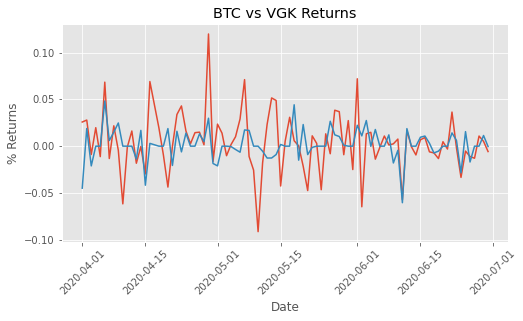

In [39]:
# Change color theme
plt.style.use('ggplot')

# Extract quarter 2 data to be plotted
btc_q2 = get_data(ret_data, 2020, 2020, 4, 7, "BTC").reset_index()
equities_q2 = get_data(ret_data, 2020, 2020, 4, 7, "VGK").reset_index()

# Plot figure
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(btc_q2["Date"], btc_q2["BTC"])
ax.plot(equities_q2["Date"], equities_q2["VGK"])

# Setting the title
ax.set_title("BTC vs VGK Returns")

# Setting the ylabels and xlabels
ax.set_ylabel('% Returns')
ax.set_xlabel('Date')

# Rotate xticks
plt.xticks(rotation = 45)

plt.show()

### 4.3 Fit a non-Gaussian copula to the returns of those 2 series.  Some possibilities are Student's T, Clayton, Gumbel, choose your own, …


In [40]:
# Data and histograms
def plotData(x_value, y_value):

    fig = plt.figure()
    fig.add_subplot(2,2,1)
    plt.hist(x_value,bins=20,color='green',alpha=0.8,align='mid')
    plt.title('X variable distribution')
    fig.add_subplot(2,2,3)
    plt.scatter(x_value,y_value,marker="o",alpha=0.8)
    fig.add_subplot(2,2,4)
    plt.title('Joint X,Y')
    plt.hist(y_value,bins=20,orientation='horizontal',color='red',alpha=0.8,align='mid')
    plt.title('Y variable distribution')    
    plt.show()
    
# Generate Copula
def generateCopulas(x_value, y_value):

    fig = plt.figure()
    clayton = Copula(x_value,y_value,family='clayton')
    uc,vc = clayton.generate_uv(1000)
    fig.add_subplot(2,2,2)
    plt.scatter(uc,vc,marker='.',color='red')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.title('Clayton copula')
    plt.show()

Non-Gaussian Coupula of BTC

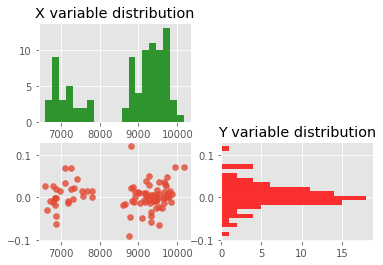

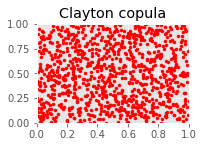

I ran this, and I didn't get an error.


In [41]:
q2_btc_closing = get_data(adj_close_data, 2020, 2020, 4, 7, "BTC").reset_index()["BTC"]
q2_btc_returns = get_data(ret_data, 2020, 2020, 4, 7, "BTC").reset_index()["BTC"]

plotData(q2_btc_closing, q2_btc_returns)
generateCopulas(q2_btc_closing, q2_btc_returns)
print("I ran this, and I didn't get an error.")

Non-Gaussian Coupula of VGK

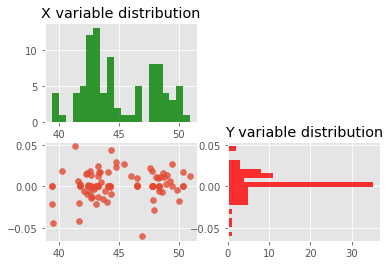

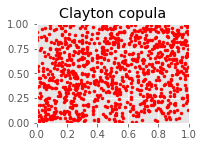

I ran this, and I didn't get an error.


In [42]:
q2_vgk_closing = get_data(adj_close_data, 2020, 2020, 4, 7, "VGK").reset_index()["VGK"]
q2_vgk_returns = get_data(ret_data, 2020, 2020, 4, 7, "VGK").reset_index()["VGK"]

plotData(q2_vgk_closing, q2_vgk_returns)
generateCopulas(q2_vgk_closing, q2_vgk_returns)
print("I ran this, and I didn't get an error.")

## 5. Category 1 Models: Just use 1 variable.
### 5.1 - 5.2 - 5.3 - 5.4

We will develope two strategies, first we use an ARMA model to predict the future returns and generate buying and selling signals. Then in the second one, we use some sort of Volatility Trading startegy using GARCH, meaning that we will forecast future volatility and produce signals off of that.

The rationale in the ARMA strategy is buying when the the predicted return is positive and selling when the predicted return is negative. In the GARCH strategy, we will buy in periods of low volatility and sell in periods of high volatility or in other words, high risk.

The setting for our backtesting is very simple and straight-foreward, we invest our whole money in each buy order, and by selling we pull out our money out of the market, meaning that there won't be any shorting position. Transaction costs and slipage cost are ignored.

We chose Bitcoin as our base traded asset.

### 5.5 - The first strategy needs to include some form of ARMA. 
We will first test if our return series is stationary using ADF test, the we will incorporate "auto_arima" function from pmdarima to find best MA and AR values for our ARMA model.

In [43]:
# FIRST SCENARIO: Training on Q2 and benchmarking on Q3 

# Checking for stationarity
p_value_adf = adfuller(ret_data['BTC']["2020-04-01" : "2020-06-30"])[1]
if p_value_adf < 0.05:
    print("The series is stationary")
    btc_stationary_q2 = ret_data['BTC']["2020-04-01" : "2020-06-30"]

else:
    print("The series is not stationary")
    


The series is stationary


In [44]:
# Finding the best ARMA model based on AIC
## The auto_arima function below, iteratively checks values of p and q between 1 to 10, the assumptions
## are: Stationarity of the input data, and lack of any seasonality.

auto_arima(btc_stationary_q2, stationary=True, 
           start_p=1, max_p = 10, start_q = 1, 
           max_q = 10, seasonal = False, trace= True,
           information_criterion = 'aic')

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-360.510, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-364.165, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-362.465, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-362.476, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-364.784, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.342 seconds


ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

##### Interpretation of results:
The best reported model is a constant line, but for sake of verbosity we go with ARMA(1,1) model, since the reported AIC values does not have much difference.

In [45]:
# Fitting ARMA(1,1) model 
arma_btc_q2 = ARIMA(endog = btc_stationary_q2, order = (1, 0, 1)).fit()
arma_btc_q2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    BTC   No. Observations:                   90
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 184.724
Date:                Sat, 23 Oct 2021   AIC                           -361.447
Time:                        18:10:45   BIC                           -351.448
Sample:                             0   HQIC                          -357.415
                                 - 90                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.003      1.391      0.164      -0.002       0.009
ar.L1          0.6402      0.465      1.376      0.169      -0.272       1.552
ma.L1         -0.7329      0.401     -1.829      0.067      -1.518       0.053
sigma2         0.0010      0.000      9.607      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                21.70
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                             0.38
Prob(H) (two-sided):                  0.04   Kurtosis:                         5.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Note:
We adopt a rolling forecast procedure, meaning that we fit the model again using the newly realized data points and then predict the next return. 

The return is: 19.905826221585343%
In and out of the Market Status:
Date
2020-07-01    1.0
2020-07-02    1.0
2020-07-03    1.0
2020-07-04    1.0
2020-07-05    1.0
             ... 
2020-09-26    1.0
2020-09-27    1.0
2020-09-28    1.0
2020-09-29    1.0
2020-09-30    1.0
Length: 92, dtype: float64


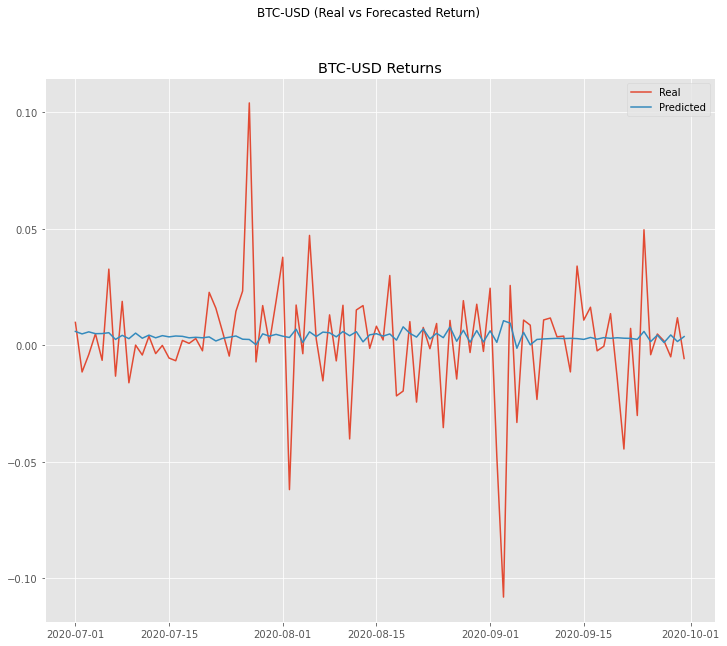

In [46]:
# BUY when the forecasted return is above 0 and SELL when the forecast 
## Iterating through the data for forecasting and portfolio calculation
### Since we have log returns, we can simply add them up

forecasted_rets = pd.Series(index = ret_data['BTC']["2020-07-01" : "2020-09-30"].index)
in_or_out_of_market = pd.Series(index = ret_data['BTC']["2020-07-01" : "2020-09-30"].index)
ret = 0

for ind in forecasted_rets.index:
    
    arma_btc_q2 = ARIMA(endog = ret_data['BTC']["2020-04-01" : ind - timedelta(days = 1)] , order = (1, 0, 1)).fit()
    forecasted_rets[ind] = arma_btc_q2.forecast()
    if forecasted_rets[ind] > 0:
        ret += ret_data['BTC'][ind]
        in_or_out_of_market[ind] = 1 # One indicates being IN THE MARKET
    else:
        in_or_out_of_market[ind] = 0 # Zero indicates being OUT OF THE MARKET
        
fig, axs = plt.subplots(1, figsize = (12, 10) )
fig.suptitle('BTC-USD (Real vs Forecasted Return)')
axs.plot(ret_data['BTC']["2020-07-01" : "2020-09-30"], label = "Real")
axs.plot(forecasted_rets, label = "Predicted")
axs.legend()
axs.set_title("BTC-USD Returns")

print("The return is: {}%".format(ret*100))
print("In and out of the Market Status:")
print(in_or_out_of_market)

In [47]:
# SECOND SCENARIO: Training on Q3 and benchmarking on Q4 

# Checking for stationarity
p_value_adf = adfuller(ret_data['BTC']["2020-07-01" : "2020-09-30"])[1]
if p_value_adf < 0.05:
    print("The series is stationary")
    btc_stationary_q3 = ret_data['BTC']["2020-07-01" : "2020-09-30"]

else:
    print("The series is not stationary")
    
    

The series is stationary


In [48]:
# Finding the best ARMA model based on AIC
## The auto_arima function below, iteratively checks values of p and q between 1 to 10, the assumptions
## are: Stationarity of the input data, and lack of any seasonality.

auto_arima(btc_stationary_q2, stationary=True, 
           start_p=1, max_p = 10, start_q = 1, 
           max_q = 10, seasonal = False, trace= True,
           information_criterion = 'aic')

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-360.510, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-364.165, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-362.465, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-362.476, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-364.784, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.322 seconds


ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

##### Interpretation of results:
The best reported model is a constant line, but for sake of verbosity we go with ARMA(1,1) model, since the reported AIC values does not have much difference.

In [49]:
# Fitting ARMA(1,1) model 
arma_btc_q3 = ARIMA(endog = btc_stationary_q3, order = (1, 0, 1)).fit()
arma_btc_q3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    BTC   No. Observations:                   92
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 211.613
Date:                Sat, 23 Oct 2021   AIC                           -415.227
Time:                        18:11:38   BIC                           -405.139
Sample:                    07-01-2020   HQIC                          -411.155
                         - 09-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.003      0.673      0.501      -0.003       0.007
ar.L1         -0.5081      0.715     -0.711      0.477      -1.909       0.893
ma.L1          0.3610      0.780      0.463      0.644      -1.169       1.890
sigma2         0.0006    5.5e-05     10.689      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               268.20
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.73   Skew:                            -0.62
Prob(H) (two-sided):                  0.13   Kurtosis:                        11.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The return is: 86.40003800143283%
In and out of the Market Status:
Date
2020-10-01    1.0
2020-10-02    1.0
2020-10-03    1.0
2020-10-04    1.0
2020-10-05    1.0
             ... 
2020-12-27    1.0
2020-12-28    1.0
2020-12-29    1.0
2020-12-30    1.0
2020-12-31    1.0
Length: 89, dtype: float64


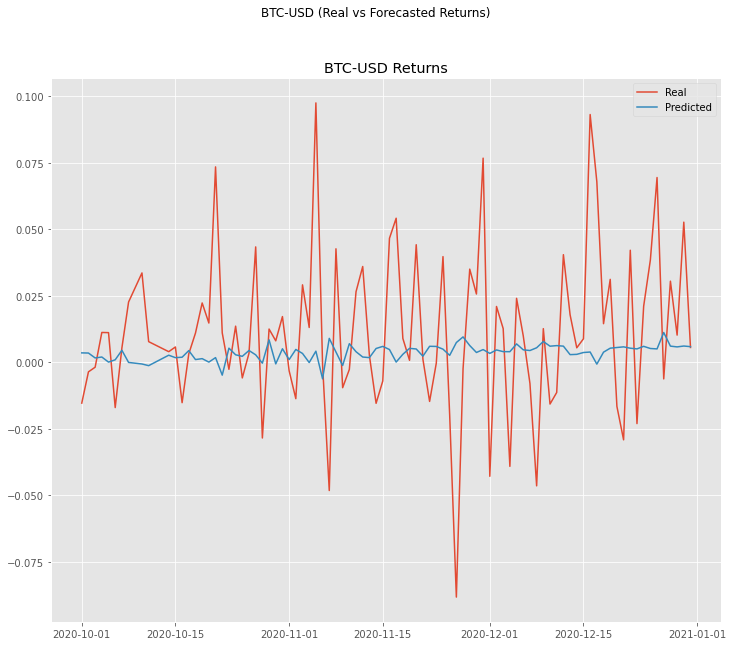

In [51]:
# BUY when the forecasted return is above 0 and SELL when the forecast 
## Iterating through the data for forecasting and portfolio calculation
### Since we have log returns, we can simply add them up

forecasted_rets = pd.Series(index = ret_data['BTC']["2020-10-01" : "2020-12-31"].index)
in_or_out_of_market = pd.Series(index = ret_data['BTC']["2020-10-01" : "2020-12-31"].index)
ret = 0

for ind in forecasted_rets.index:
    
    arma_btc_q3 = ARIMA(endog = ret_data['BTC']["2020-07-01" : ind - timedelta(days = 1)] , order = (1, 0, 1)).fit()
    forecasted_rets[ind] = arma_btc_q3.forecast()
    if forecasted_rets[ind] > 0:
        ret += ret_data['BTC'][ind]
        in_or_out_of_market[ind] = 1 # One indicates being IN THE MARKET
    else:
        in_or_out_of_market[ind] = 0 # Zero indicates being OUT OF THE MARKET
        
fig, axs = plt.subplots(1, figsize = (12, 10) )
fig.suptitle('BTC-USD (Real vs Forecasted Returns)')
axs.plot(ret_data['BTC']["2020-10-01" : "2020-12-31"], label = "Real")
axs.plot(forecasted_rets, label = "Predicted")
axs.legend()
axs.set_title("BTC-USD Returns")

print("The return is: {}%".format(ret*100))
print("In and out of the Market Status:")
print(in_or_out_of_market)

### 5.6 - The second strategy needs to include some form of GARCH.
Since we tested our data for stationarity and it passed, we will proceed with using PACF and ACF charts to find best MA and AR values for our GARCH model, and then fitting it and conducting forecasts.

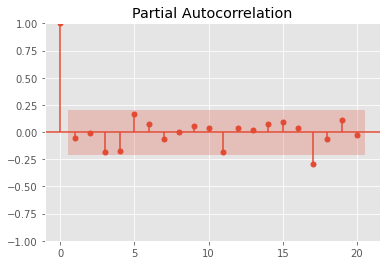

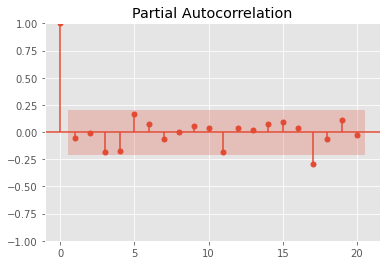

In [52]:
# FIRST SCENARIO: Training on Q2 and benchmarking on Q3 
plot_pacf(btc_stationary_q2)

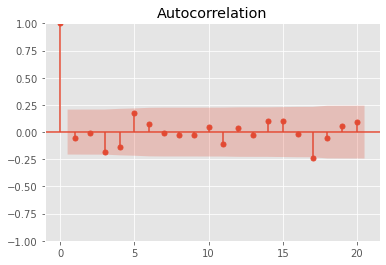

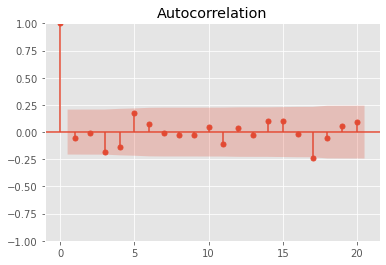

In [53]:
plot_acf(btc_stationary_q2)

##### Interpretation of results:
Much like our ARMA model, there is no clear indication of any MA or AR processes in our data, again for sake of context we go with GARCH(1, 1) and hope for the best.

We could use M-GARCH or an EGARCH model, but since GARCH seems more than enough for our data, to avoid any over-specification we only use the simple GARCH(1, 1) without any extra bits.

In [54]:
btc_garch_q2 = arch_model(y = btc_stationary_q2,
                          mean = "Constant", 
                          vol = "GARCH",
                          p =  1,
                          q = 1, 
                          dist = "normal")
btc_garch_q2.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 101.49247709970281
Iteration:      2,   Func. Count:     15,   Neg. LLF: 68.00466295163567
Iteration:      3,   Func. Count:     24,   Neg. LLF: -184.0820913883987
Iteration:      4,   Func. Count:     29,   Neg. LLF: -184.08220401787744
Iteration:      5,   Func. Count:     34,   Neg. LLF: -184.08226945143187
Iteration:      6,   Func. Count:     39,   Neg. LLF: -184.08229004340967
Iteration:      7,   Func. Count:     44,   Neg. LLF: -184.0822916265253
Iteration:      8,   Func. Count:     48,   Neg. LLF: -184.08229162627197
Optimization terminated successfully    (Exit mode 0)
            Current function value: -184.0822916265253
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 8


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    BTC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                184.082
Distribution:                  Normal   AIC:                          -360.165
Method:            Maximum Likelihood   BIC:                          -350.165
                                        No. Observations:                   90
Date:                Sat, Oct 23 2021   Df Residuals:                       89
Time:                        18:19:53   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         3.8893e-03  3.320e-03      1.172      0.241 

### Note:
We adopt a rolling forecast procedure, meaning that we fit the model again using the newly realized data points and then predict the next volatility of return. 

One has to pay attention that we are trying to predict volatilities, not the returns.

The return is: 16.595821508173536%
In and out of the Market Status:
Date
2020-07-01    1.0
2020-07-02    1.0
2020-07-03    1.0
2020-07-04    1.0
2020-07-05    1.0
             ... 
2020-09-26    1.0
2020-09-27    1.0
2020-09-28    1.0
2020-09-29    1.0
2020-09-30    1.0
Length: 92, dtype: float64


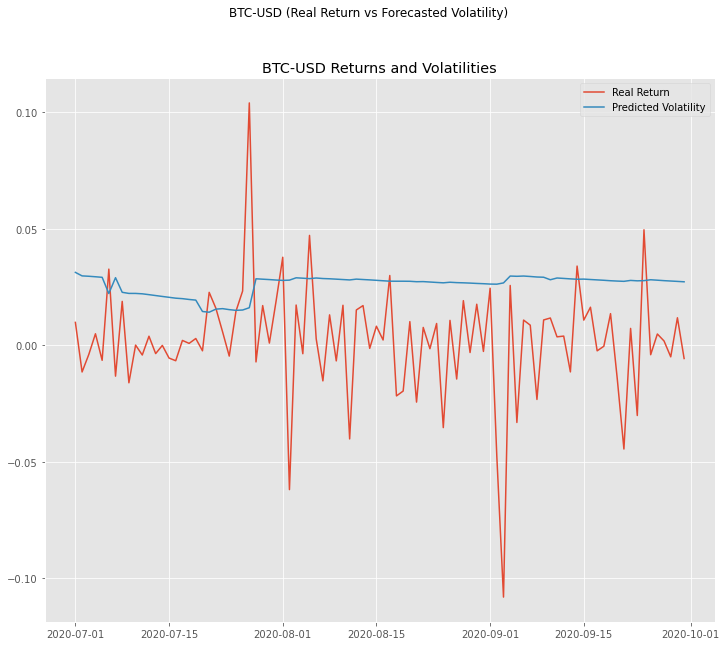

In [56]:
# BUY when the forecasted volatility is below 5%, Sell when it is above that
## Iterating through the data for forecasting and portfolio calculation
### Since we have log returns, we can simply add them up

forecasted_vols = pd.Series(index = ret_data['BTC']["2020-07-01" : "2020-09-30"].index)
in_or_out_of_market = pd.Series(index = ret_data['BTC']["2020-07-01" : "2020-09-30"].index)
ret = 0

for ind in forecasted_vols.index:
    
    garch_btc_q2 = arch_model(y = ret_data['BTC']["2020-04-01" : ind - timedelta(days = 1)] , 
                              mean = "Constant", 
                              vol = "GARCH",
                              p =  1,
                              q = 1, 
                              dist = "normal").fit(disp = "off")
    forecasted_vols[ind] = np.sqrt(garch_btc_q2.forecast(horizon = 1).variance.values[-1][0])
    if float(forecasted_vols[ind]) < 0.05:
        ret += ret_data['BTC'][ind]
        in_or_out_of_market[ind] = 1 # One indicates being IN THE MARKET
    else:
        in_or_out_of_market[ind] = 0 # Zero indicates being OUT OF THE MARKET
        
fig, axs = plt.subplots(1, figsize = (12, 10) )
fig.suptitle('BTC-USD (Real Return vs Forecasted Volatility)')
axs.plot(ret_data['BTC']["2020-07-01" : "2020-09-30"], label = "Real Return")
axs.plot(forecasted_vols, label = "Predicted Volatility")
axs.legend()
axs.set_title("BTC-USD Returns and Volatilities")

print("The return is: {}%".format(ret*100))
print("In and out of the Market Status:")
print(in_or_out_of_market)

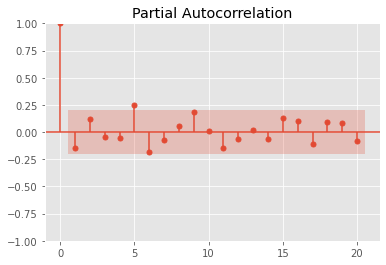

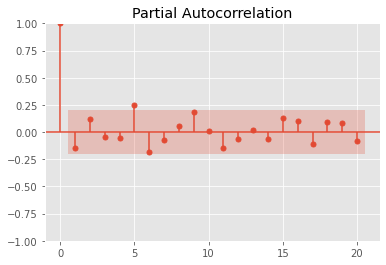

In [57]:
# SECOND SCENARIO: Training on Q3 and benchmarking on Q4 
plot_pacf(btc_stationary_q3)

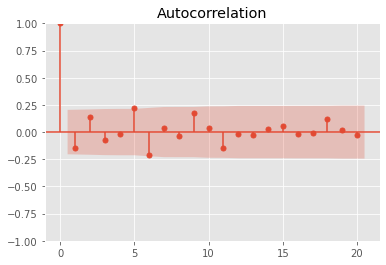

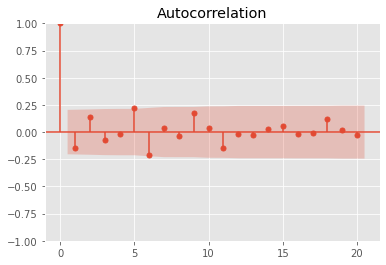

In [58]:
plot_acf(btc_stationary_q3)

##### Interpretation of results:
Much like our ARMA model, there is no clear indication of any MA or AR processes in our data, again for sake of context we go with GARCH(1, 1) and hope for the best.

We could use M-GARCH or an EGARCH model, but since GARCH seems more than enough for our data, to avoid any over-specification we only use the simple GARCH(1, 1) without any extra bits.

In [59]:
btc_garch_q3 = arch_model(y = btc_stationary_q3,
                          mean = "Constant", 
                          vol = "GARCH",
                          p =  1,
                          q = 1, 
                          dist = "normal")
btc_garch_q3.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 755854.6557409707
Iteration:      2,   Func. Count:     17,   Neg. LLF: 1200.0511872552163
Iteration:      3,   Func. Count:     23,   Neg. LLF: -213.06970036951233
Iteration:      4,   Func. Count:     30,   Neg. LLF: 136.63597107148667
Iteration:      5,   Func. Count:     36,   Neg. LLF: -186.22923602693052
Iteration:      6,   Func. Count:     42,   Neg. LLF: -218.68403759909293
Iteration:      7,   Func. Count:     47,   Neg. LLF: -218.93624270466657
Iteration:      8,   Func. Count:     53,   Neg. LLF: -184.05750331454857
Iteration:      9,   Func. Count:     59,   Neg. LLF: -221.22741650643042
Iteration:     10,   Func. Count:     64,   Neg. LLF: -221.24423506805095
Iteration:     11,   Func. Count:     69,   Neg. LLF: -221.22846315637645
Iteration:     12,   Func. Count:     75,   Neg. LLF: -221.12012478138433
Iteration:     13,   Func. Count:     81,   Neg. LLF: -221.24843630150667
Iteration:     14,   Func. Count:     86, 

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    BTC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                221.248
Distribution:                  Normal   AIC:                          -434.497
Method:            Maximum Likelihood   BIC:                          -424.410
                                        No. Observations:                   92
Date:                Sat, Oct 23 2021   Df Residuals:                       91
Time:                        18:22:31   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.6052e-03  1.265e-03      1.269      0.205 

The return is: 98.15047526801717%
In and out of the Market Status:
Date
2020-10-01    1.0
2020-10-02    1.0
2020-10-03    1.0
2020-10-04    1.0
2020-10-05    1.0
             ... 
2020-12-27    1.0
2020-12-28    1.0
2020-12-29    1.0
2020-12-30    1.0
2020-12-31    1.0
Length: 89, dtype: float64


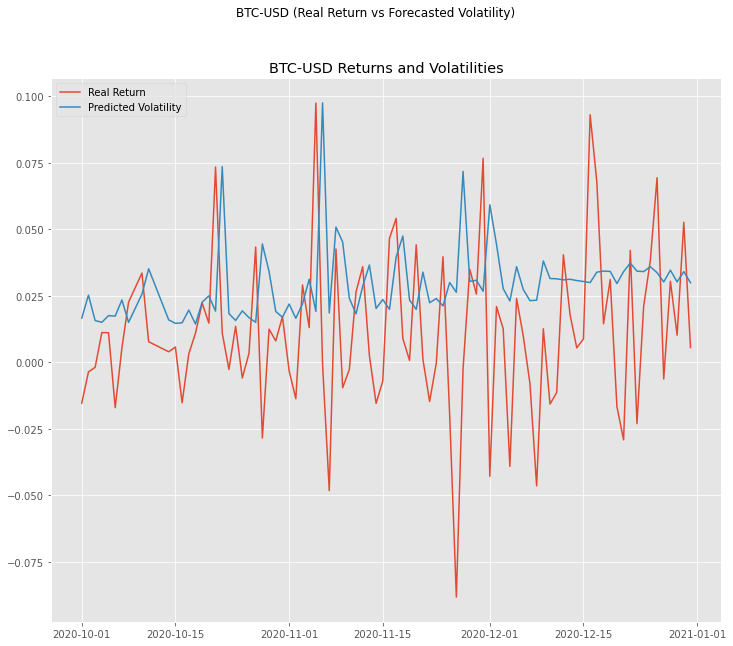

In [60]:
# BUY when the forecasted volatility is below 5%, Sell when it is above that
## Iterating through the data for forecasting and portfolio calculation
### Since we have log returns, we can simply add them up

forecasted_vols = pd.Series(index = ret_data['BTC']["2020-10-01" : "2020-12-31"].index)
in_or_out_of_market = pd.Series(index = ret_data['BTC']["2020-10-01" : "2020-12-31"].index)
ret = 0

for ind in forecasted_vols.index:
    
    garch_btc_q3 = arch_model(y = ret_data['BTC']["2020-07-01" : ind - timedelta(days = 1)] , 
                              mean = "Constant", 
                              vol = "GARCH",
                              p =  1,
                              q = 1, 
                              dist = "normal").fit(disp = "off")
    forecasted_vols[ind] = np.sqrt(garch_btc_q3.forecast(horizon = 1).variance.values[-1][0])
    if float(forecasted_vols[ind]) < 0.05:
        ret += ret_data['BTC'][ind]
        in_or_out_of_market[ind] = 1 # One indicates being IN THE MARKET
    else:
        in_or_out_of_market[ind] = 0 # Zero indicates being OUT OF THE MARKET
        
fig, axs = plt.subplots(1, figsize = (12, 10) )
fig.suptitle('BTC-USD (Real Return vs Forecasted Volatility)')
axs.plot(ret_data['BTC']["2020-10-01" : "2020-12-31"], label = "Real Return")
axs.plot(forecasted_vols, label = "Predicted Volatility")
axs.legend()
axs.set_title("BTC-USD Returns and Volatilities")

print("The return is: {}%".format(ret*100))
print("In and out of the Market Status:")
print(in_or_out_of_market)

### 5.7 Which of the 2 models do you prefer?  Explain your answer in quantitative terms.

Based on the calculated returns, we can see that our ARMA model outperforms the GARCH during Q3, but GARCH startegy beats ARMA in the Q4. Beside a ton of hyperparameters in our startegies that can change our end results and subsequently our interpretations, we are can say that reagradless of startegy settings, GARCH model is much better than ARMA in predicting volatility of returns during high fluctuations, which is implicit in the p-values of parameters or GARCH nad ARMA when fitting on Q3 data and predicting Q4. And we know most of the high fluctuation periods are due to bad news or namely "corrections" in the market as an stylized fact, in other words, there are steady growth periods and chaotic corrections or crashes. By utilizing a risk averse strategy based on GARCH rather than merely trying to predict the unpredictable with an ARMA, we ended up with better ROI. And if we add up ROI of the models during the two trading periods, we can see that in total GARCH wins.

Therefore our preference goes to GARCH.

## 6. Category 2 Models: Just use 2 variables: the one you are trading, and an additional (called exogeneous variable) to enhance prediction

#### 6.1 Use the same series as you did in the previous question
 We will choose Bitcoin as our main data series and Equity ETF as exogenous variable.

In [134]:
def fit_arima(data, exog= None):
    model = ARIMA(data, exog=exog, order=(2,0,2))
    model_fit = model.fit()
    return model_fit

def fit_varmax(data, exog= None):
    model = VARMAX(data, exog=exog, order=(2,1))
    model_fit = model.fit()
    return model_fit

#### 6.2 Use Q2 data for estimation, and Q3 data for evaluating performance.

The returns is approximately 101%

In [123]:
q2_btc_returns = get_data(ret_data, 2020, 2020, 4, 7, "BTC").reset_index()["BTC"]
q2_vgk_returns = get_data(ret_data, 2020, 2020, 4, 7, "VGK").reset_index()["VGK"]
q3_btc_returns = get_data(ret_data, 2020, 2020, 7, 10, "BTC").reset_index()["BTC"]
q3_vgk_returns = get_data(ret_data, 2020, 2020, 7, 10, "VGK").reset_index()["VGK"]

model = fit_arima(q2_btc_returns, q2_vgk_returns)
return_pred = model.predict(exog=q3_vgk_returns, start=q2_btc_returns.shape[0], end=q2_btc_returns.shape[0] + q3_btc_returns.shape[0] - 1).values
signal = np.where(return_pred > 0, 1, -1)
return_q3 = np.product(q3_btc_returns * signal + 1) - 1
return_q3

1.0135675110145441

#### 6.3 Repeat, using Q3 data for estimation, and Q4 data for evaluating performance

The returns is approximately 44.3%

In [127]:
q3_btc_returns = get_data(ret_data, 2020, 2020, 7, 10, "BTC").reset_index()["BTC"]
q3_vgk_returns = get_data(ret_data, 2020, 2020, 7, 10, "VGK").reset_index()["VGK"]
q4_btc_returns = get_data(ret_data, 2020, 2021, 10, 1, "BTC").reset_index()["BTC"] 
q4_vgk_returns = get_data(ret_data, 2020, 2021, 10, 1, "VGK").reset_index()["VGK"] 

model = fit_arima(q3_btc_returns, q3_vgk_returns)
return_pred = model.predict(exog=q4_vgk_returns, start=q3_btc_returns.shape[0], end=q3_btc_returns.shape[0] + q4_btc_returns.shape[0] - 1).values
signal = np.where(return_pred > 0, 1, -1)
return_q4 = np.product(q4_btc_returns * signal + 1) - 1
return_q4


0.4431098827855444

#### 6.4 Build 3 trading strategies. + 6.5 The 1st strategy should include a form of VAR or VARMA.  

In [ ]:
## No idea

#### 6.6 The 2nd strategy should include multivariate GARCH.  There are several possibilities.  

Here we combine the use of Garch with Arima to arrive at the ARMA-GARCH model.

In [140]:
def fit_garch(data, garch_type="GARCH"):
    if garch_type == "TARCH":
        garch = arch_model(data, vol='TGARCH', p=1, o=1, q=1, power=1)
    else:
        garch = arch_model(data, vol=garch_type, p=1, o=0, q=1)
    garch_fitted = garch.fit()
    print(garch_fitted.summary())
    if garch_type != "FIGARCH":
        omega = garch_fitted.params["omega"]
        alpha = garch_fitted.params["alpha[1]"]
        beta = garch_fitted.params["beta[1]"]
        print(f"Unconditional variance: {omega/(1 - alpha - beta)}")
    return garch_fitted

In [172]:
q2_btc_returns = get_data(ret_data, 2020, 2020, 4, 7, "BTC").reset_index()["BTC"]
model = fit_arima(q2_btc_returns, q2_vgk_returns)
return_pred = model.predict(exog=q3_vgk_returns, start=q2_btc_returns.shape[0], end=q2_btc_returns.shape[0] + q3_btc_returns.shape[0] - 1).values
signal = np.where(return_pred > 0, 1, -1)
return_q3 = np.product(q3_btc_returns * signal + 1) - 1
return_q3

# fit a GARCH(1,1) model on the residuals of the ARIMA model
model = fit_garch(q2_btc_returns)
garch_forecast = model.forecast(horizon=1)
predicted_et = garch_forecast.mean['h.1'].iloc[-1]

return_q3 = return_q3 + predicted_et
print("The returns is", return_q3)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 101.49247709970281
Iteration:      2,   Func. Count:     15,   Neg. LLF: 68.00466295163567
Iteration:      3,   Func. Count:     24,   Neg. LLF: -184.0820913883987
Iteration:      4,   Func. Count:     29,   Neg. LLF: -184.08220401787744
Iteration:      5,   Func. Count:     34,   Neg. LLF: -184.08226945143187
Iteration:      6,   Func. Count:     39,   Neg. LLF: -184.08229004340967
Iteration:      7,   Func. Count:     44,   Neg. LLF: -184.0822916265253
Iteration:      8,   Func. Count:     48,   Neg. LLF: -184.08229162627197
Optimization terminated successfully    (Exit mode 0)
            Current function value: -184.0822916265253
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 8
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    BTC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-

#### 6.7 The 3rd strategy should attempt to include cointegration.  Note that if cointegration is not found, then justify the lack of existence for cointegration in quantitative terms.

Given that p-value < 0.01 for all tests, we conclude that there are cointegrating vectors.

In [170]:
from statsmodels.tsa.stattools import adfuller, coint

q2_btc_returns = get_data(ret_data, 2020, 2020, 4, 7, "BTC").reset_index()["BTC"]
q2_vgk_returns = get_data(ret_data, 2020, 2020, 4, 7, "VGK").reset_index()["VGK"]
q2_gold_returns = get_data(ret_data, 2020, 2020, 4, 7, "GLD").reset_index()["GLD"]

print(coint(q2_btc_returns, np.array([q2_vgk_returns, q2_gold_returns]).T))
print(coint(q2_vgk_returns, np.array([q2_btc_returns, q2_gold_returns]).T))
print(coint(q2_gold_returns, np.array([q2_vgk_returns, q2_btc_returns]).T))

(-3.7219743379755807, 0.05249239182963255, array([-4.46005898, -3.83820607, -3.52247298]))
(-5.508525153998414, 8.719628627588787e-05, array([-4.46005898, -3.83820607, -3.52247298]))
(-9.967914411796926, 1.2560441593036165e-16, array([-4.46005898, -3.83820607, -3.52247298]))
